In [65]:
import pandas as pd

file_path = 'data.csv'
data = pd.read_csv(file_path)

data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True) 

X = data.drop(['ggr'], axis=1)
y = data['ggr']

# Retraining model on the whole dataset

In [66]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split

# Normalizing features and target
scaler_x = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Function to create sequences for LSTM model
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 30

X_seq, y_seq = create_dataset(X_scaled, y_scaled, time_steps)

X_seq.shape, y_seq.shape


((1313, 30, 5), (1313, 1))

Epoch 1/200
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0211 - val_loss: 0.0037
Epoch 2/200
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 3/200
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0026 - val_loss: 0.0034
Epoch 4/200
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0032 - val_loss: 0.0036
Epoch 5/200
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 6/200
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0028 - val_loss: 0.0038
Epoch 7/200
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0025 - val_loss: 0.0034
Epoch 8/200
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0031 - val_loss: 0.0036
Epoch 9/200
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0029 - val_loss: 0.0034
Epoch 10/200
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 11/200
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0029 - val_loss: 0.0034
Epoch 12/200
169/169 ━━━━━━━━━

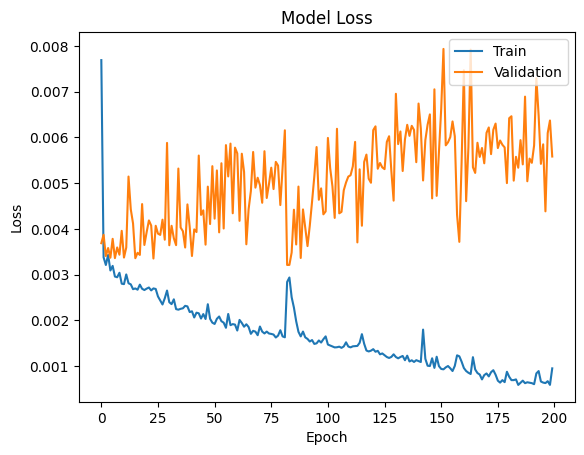

In [67]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt


model = Sequential([
    Input(shape=(X_seq.shape[1], X_seq.shape[2])),
    LSTM(100, return_sequences=True),
    Dropout(0.1), 
    LSTM(50, return_sequences=True),
    Dropout(0.2), 
    LSTM(30), 
    Dense(1)  
])

model.compile(optimizer='Adam', loss='mean_squared_error')
history = model.fit(
    X_seq, 
    y_seq, 
    epochs=200,  
    batch_size=7,
    validation_split=0.1,
    verbose=1
)

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [71]:
# Save the model to disk
model.save_weights('models/lstm_final.weights.h5')

# Final Forecast

In [68]:
# Load the new feature data
new_features = pd.read_csv('out_features.csv')
new_features['date'] = pd.to_datetime(new_features['date'])
new_features.set_index('date', inplace=True)

# Normalize the features using the same scaler used during training
scaler_x = MinMaxScaler()
scaler_x.fit(X) 
new_features_scaled = scaler_x.transform(new_features)

new_features_sequence = np.array([new_features_scaled])  # This reshapes it to (1, 30, number_of_features)

In [69]:
current_input = new_features_sequence.copy()
predictions = []
for i in range(30):  # Predict for each of the next 30 days
    current_prediction = model.predict(current_input)
    predictions.append(current_prediction[0, 0])  

    current_input = np.roll(current_input, -1, axis=1)

    current_input[0, -1, :] = np.zeros_like(current_input[0, -1, :]) 
    current_input[0, -1, 0] = current_prediction[0, 0] 

# Convert predictions to the original scale
predictions_original_scale = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━

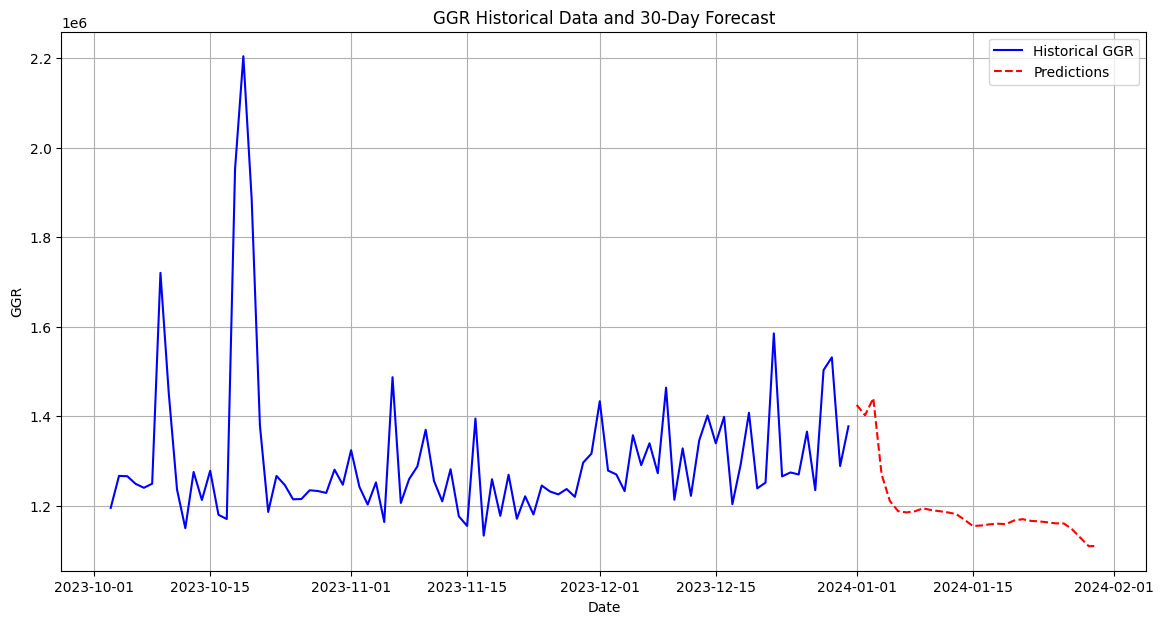

In [70]:
last_date = data.index[-1]
prediction_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

# Plotting the historical data
plt.figure(figsize=(14, 7))
plt.plot(data['ggr'][-90:], label='Historical GGR', color='blue')

# Plotting the predictions
plt.plot(prediction_dates, predictions_original_scale.flatten(), label='Predictions', linestyle='--', color='red')

# Add labels and legend
plt.title('GGR Historical Data and 30-Day Forecast')
plt.xlabel('Date')
plt.ylabel('GGR')
plt.legend()
plt.grid(True)
plt.show()